# Biodiversity in National Parks
*Author: Amelia Papa*
### Introduction

This project aims to interpret fictional data from a National Park about species' conservation status in different locations. The data was obtained from [Codecademy.com](https://www.codecademy.com) for training purposes. A few questions raised:
- What is the distribution of conservation status for species?
- Is there higher likelihood for certain species to be classified as endangered?
- Is there a statistical significance between species and conservation status?
- Which animal is sighted more commonly in each location?

### Preparations
First, load the necessary python modules:



In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

### Read in the data
Observations.csv and Species_info.csv are read in as dataframes named observations and species respectively and content are checked with .head(). The species_info.csv contains information on different species of the parks. The observations.csv contains data recorded from species sighted in different locations in 7 days.

In [10]:
species = pd.read_csv('species_info.csv')
species_info.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [6]:
observations = pd.read_csv('observations.csv')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


### Exploratory Data Analysis
To explore the species data, first we find the number of distinct species. 

In [11]:
print(f"number of species:{species.scientific_name.nunique()}")

number of species:5541


Next, we are interested in the number of taxonomic categories represented in the dat, as well as the counts of category. It seems vascular plants dominate the dataset with 4,470 species recorded, followed by birds (521 species) and non-vascular plants (333 species).

In [14]:
print(f"number of categories:{species.category.nunique()}")
print(f"categories:{species.category.unique()}")
species.groupby("category").size()

number of categories:7
categories:['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

##### Question 1: Distribution of conservation status
The conservation status column has 4 categories, namely species of concern, endagered, threatened, in recovery and NaN values. A count of NaN values gives the number of species under no conservation status. These values will be converted to 'No Intervention'. In addition, there are 161 species of concern, 16 endangered, 10 threatened and 4 species in recovery. 

nan values:0
conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64


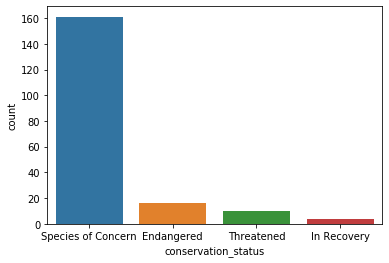

In [19]:
print(f"nan values:{species.conservation_status.isna().sum()}")
species.fillna('No Intervention', inplace=True)
print(species.groupby("conservation_status").size())
sns.countplot(species_info['conservation_status'])

Next, we are interested to differentiate the different categories for each conservation status.

In [20]:
conservationCategory = species[species.conservation_status != "No Intervention"]\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

conservationCategory

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


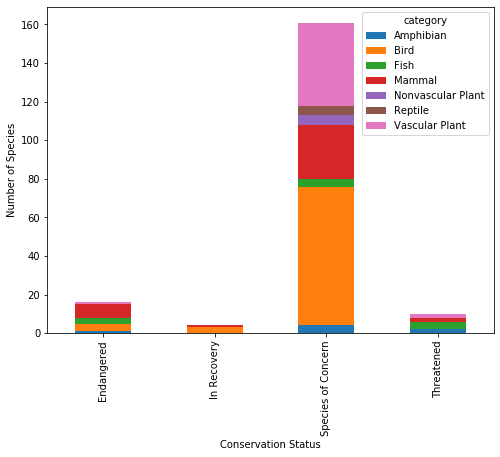

In [21]:
ax = conservationCategory.plot(kind = 'bar', figsize=(8,6), 
                               stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");

##### Question 2: Are certain species more commonly in conservation?
A new column called is_protected will include all species under any conservation status, to be compared with the 'No Intervention' species. As shown below, birds and mammals have the highest percentage of species protected in this dataset with around 15% and 17% respectively.

In [24]:
species['is_protected']= species.conservation_status != "No Intervention"
category_counts = species.groupby(['category', 'is_protected'])\
                        .scientific_name.nunique()\
                        .reset_index()\
                        .pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']
category_counts['percent_protected'] = category_counts.protected / \
                                      (category_counts.protected + category_counts.not_protected) * 100

category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


Some data wrangling is required to find which species in the mammals category are most predominantly under protection. The first step is to retrieve all common species names in the species dataset. Then duplicate words in each row should be removed, so they are not counted more than once per species.

In [26]:
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species[species.category == "Mammal"]\
    .common_names\
    .apply(remove_punctuations)\
    .str.split().tolist()

cleanRows = []

for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
cleanRows[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

Next we combine these common names onto one list for convenince. Then the number of occurrences of each word is counted and saved into words_counted. Below, the 5 most protected mammals are listed and it seems that bat species are most likely to be under some conservation status in these parks.

In [30]:
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count']).sort_values("Count", ascending = False).head(5)

,Word,Count
22,Bat,23
52,Shrew,18
70,Myotis,17
42,Mouse,16
34,Chipmunk,13


In order to find the scientific names for bat species under protection, a new column is created of boolean values to check if is_bat is True.

In [33]:
species['is_bat'] = species.common_names.str.contains(r"\bBat\b", regex = True)
species[species.is_bat].head(10)

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Intervention,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Intervention,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,No Intervention,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,No Intervention,False,True


Only the first ten rows of the updated dataset reveal that not all bat species are protected. It is worth investigating whether sightings of protected vs non-protected bats are more common. This will be presented in the Summary Figures section.

### Statistical Analysis

### Summary Figures
In this section, we will show differences in sighting for protected vs non-protected bats based on location. Secondly, the most commonly sighted animals will be visualised for each location.

Firstly, results of bat species' counts will be combined with observations to create a dataframe of bat observations across locations. This will be used to count total bat observations at each park, divided by conservation status.


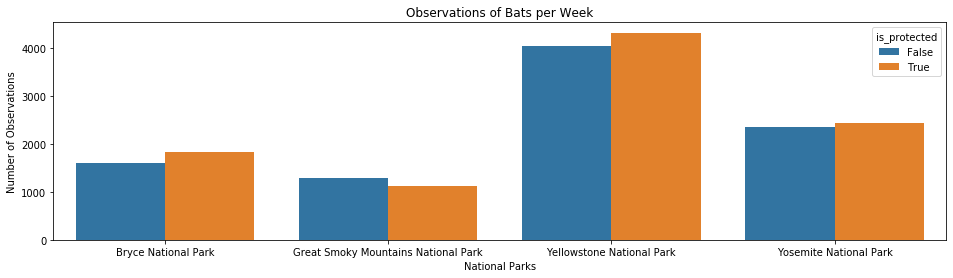

In [37]:
bat_observations = observations.merge(species[species.is_bat])
obs_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
plt.figure(figsize=(16, 4))
sns.barplot(x=obs_by_park.park_name, y= obs_by_park.observations, hue=obs_by_park.is_protected)
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats per Week')
plt.show()

### Conclusions